<a href="https://colab.research.google.com/github/AxelBadouel/machinelearningcourse/blob/main/FL_personal_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load libraries here

In [ ]:
%matplotlib inline

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import random
import copy
from tempfile import TemporaryDirectory
from sklearn.metrics import accuracy_score
from google.colab import drive
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

random.seed(42)

KeyboardInterrupt: 

# Data preprocessing

Data exploration.

The train_data and test_data declared here are going to be used in the creation of the dataset and therefore dataloader of the client.

In [ ]:
# Maybe normalize the data later on in case the accuracy needs improvement.
# If I do it here, I don't know how performing a normalization here will influence the visualization.
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


train_data = datasets.CIFAR100(
    root='data',
    train=True,
    download=True,
    transform=data_transform
)

test_data = datasets.CIFAR100(
    root='data',
    train=False,
    download=True,
    transform=data_transform
)

100%|██████████| 169M/169M [00:04<00:00, 42.2MB/s]


train_data and test_data are 2 lists of tuples. <br> For instance, train_data[0] is a tuple with train_data[0][0] being an image.

In [ ]:
tensor = train_data[0][0]
print(tensor.size())

torch.Size([3, 32, 32])


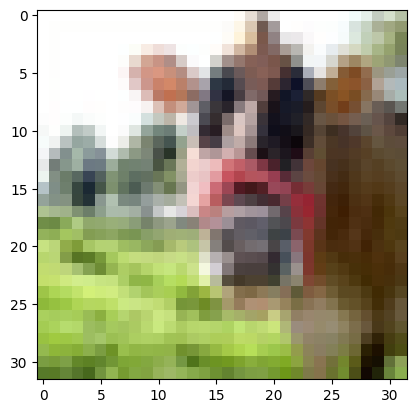

In [ ]:
mean = torch.tensor([0.5071, 0.4865, 0.4409])
std = torch.tensor([0.2673, 0.2564, 0.2762])

unnormalized_tensor = tensor * std[:, None, None] + mean[:, None, None]
unnormalized_tensor =unnormalized_tensor.permute(1, 2, 0)
plt.imshow(unnormalized_tensor)
plt.show()

In [ ]:
# Unnormalization function for visualization of the images
def unnormalize(image_tensor):
  mean = torch.tensor([0.5071, 0.4865, 0.4409])
  std = torch.tensor([0.2673, 0.2564, 0.2762])

  unnormalized_tensor = image_tensor * std[:, None, None] + mean[:, None, None]
  unnormalized_tensor = unnormalized_tensor.permute(1, 2, 0)
  return unnormalized_tensor

In [ ]:
#What is the type of the datasets and the type of each element?
print(f"train data: {train_data}\ntrain data type: {type(train_data)}")
print(f"train data type: {type(train_data[0])} with length: {len(train_data[0])}\ntrain_data[0][0]: {type(train_data[0][0])}\ntrain_data[0][1]: {type(train_data[0][1])}\n")

print(f"test data: {test_data}\ntest data type: {type(test_data)}")
print(f"test data type: {type(test_data[0])} with lenght: {len(test_data[0])}\ntest_data[0][0]: {type(test_data[0][0])}\ntest_data[0][1]: {type(test_data[0][1])}")

train data: Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
           )
train data type: <class 'torchvision.datasets.cifar.CIFAR100'>
train data type: <class 'tuple'> with length: 2
train_data[0][0]: <class 'torch.Tensor'>
train_data[0][1]: <class 'int'>

test data: Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
           )
test data type: <class 'torchvision.datasets.cifar.CIFAR100'>
test data type: <class 'tuple'> with lenght: 2
test_data[0][0]: <class 'torch.Tensor'>
test_data[0][1]: <class 'int'>


In [ ]:
print(type(test_data[0][1]))

<class 'int'>


Experiment: Not relevant to the training test we're trying to perform.

In [ ]:
# Shape
image, label = train_data[0]
print(f"image label: {label}\nimage shape: {image.shape}")

image label: 19
image shape: torch.Size([3, 32, 32])


Experiment: Not relevant to the training test we're trying to perform.

In [ ]:
# Classes available
classes = train_data.classes
print(classes)
print(f"classes length: {len(classes)}\nclass at position label: {classes[label]}")

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

Visualizing images

Experiment: Not relevant to the training test we're trying to perform.

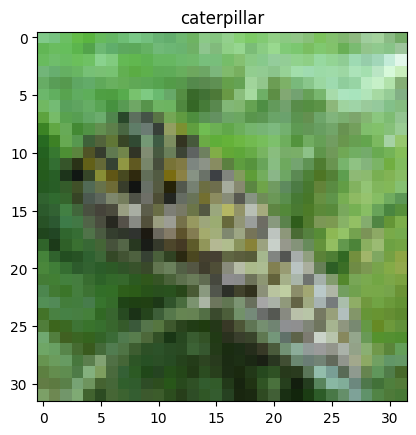

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

index = 89     #@param{min:0, max:50000}

image, label = train_data[index]
image_np = image.permute(1, 2, 0)

plt.imshow(unnormalize(image))
plt.title(classes[label])
plt.show()

Plotting a few more images.

Experiment: Not relevant to the training test we're trying to perform.

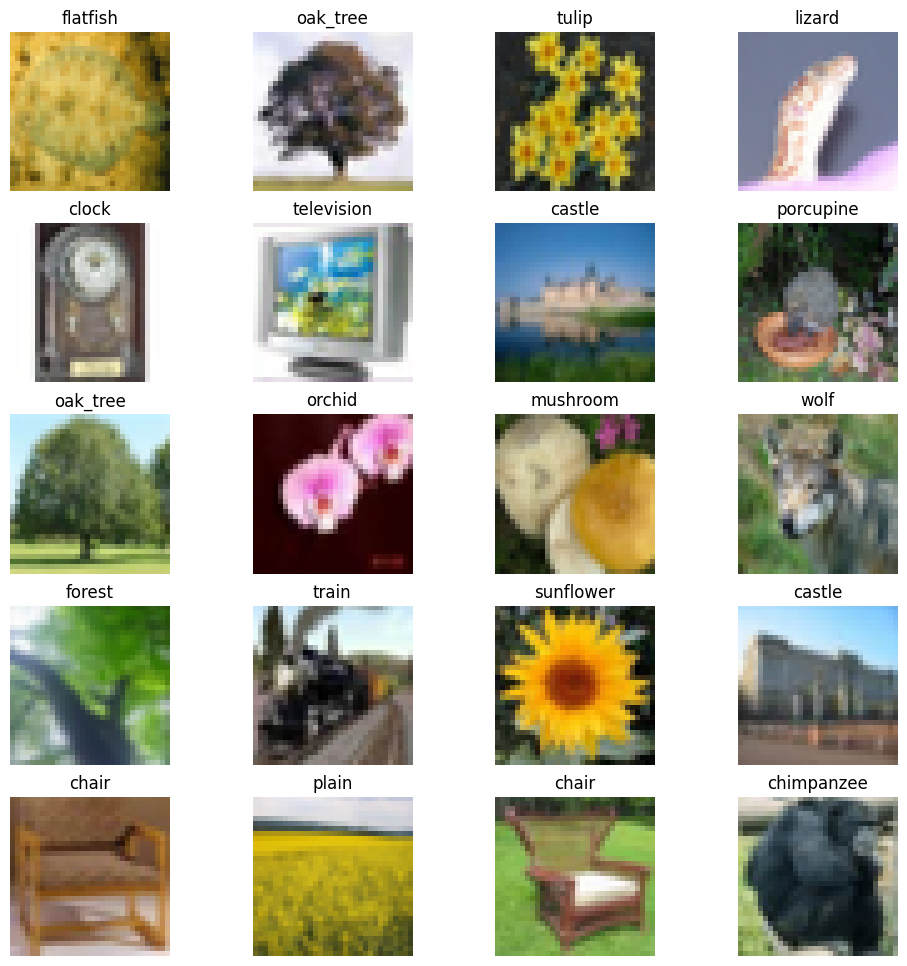

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    #torch.randint generates a random tensor between (optional) low = 0 and higher = len(train_data) of dimension size = 1[if size = (2,2) then 2x2 matrix etc]
    img_idx = torch.randint(len(train_data), size=[1]).item()
    img, label = train_data[img_idx]
    fig.add_subplot(rows, columns, i)
    plt.imshow(unnormalize(img))
    plt.title(classes[label])
    plt.axis('off')

# Objects Useful for Training and Testing

Let's add google drive to save and load models' parameters

In [ ]:
# 1. Mount Drive
drive.mount('/content/drive')

# 2. Base directory for all models. If not existing, create it
BASE_PATH = '/content/drive/My Drive/My_Colab_Models'

if not os.path.exists(BASE_PATH):
  os.makedirs(BASE_PATH)
  print(f"Created directory: {BASE_PATH}")
else:
  printf(f"Directory already exists: {BASE_PATH}")

In [ ]:
# This function automatically creates a sub-folder for the specific model and saves the file with a timestamp.

def save_model(model, model_name, extra_info=None):
    """
    Saves a model to Google Drive without conflicts.

    Args:
        model: The model object (e.g., model.state_dict())
        model_name: String, unique identifier (e.g., 'CNN_Variation_1')
        extra_info: Dict, optional metadata (accuracy, epoch, hyperparameters)
    """
    # 1. Create a dedicated folder for this specific model architecture
    model_folder = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)

    # 2. Generate a timestamp to ensure uniqueness
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 3. Construct the filename
    filename = f"{model_name}_{timestamp}.pth"
    save_path = os.path.join(model_folder, filename)

    # 4. Prepare the payload (It's best to save metadata too!)
    payload = {
        'model_state': model.state_dict(),
        'timestamp': timestamp,
        'info': extra_info  # e.g., {'epoch': 10, 'loss': 0.05}
    }

    # 5. Save
    torch.save(payload, save_path)
    print(f"✅ Model saved to: {save_path}")
    return save_path

In [ ]:
# This function allows you to grab a specific file
def load_model_params(model, file_path):
    """
    Loads parameters into a model instance.
    """
    # Load the file from Drive
    checkpoint = torch.load(file_path)

    # Load the weights
    model.load_state_dict(checkpoint['model_state'])

    # Optional: Print metadata so you know what you just loaded
    if 'info' in checkpoint:
        print(f"Loaded model info: {checkpoint['info']}")

    return model

Here is how you would use above file management functions in your training loop.

In [ ]:
# --- SIMULATING TRAINING ---

# Imagine you have two different models
model_A = MyNeuralNet()
model_B = MyTransformer()

# You train Model A...
# ... training code ...

# SAVE MODEL A
# We save it with metadata so we remember it had 98% accuracy
save_model(model_A, "ResNet_Experiment", extra_info={'accuracy': 0.98, 'epoch': 50})

# You train Model B...
# ... training code ...

# SAVE MODEL B
save_model(model_B, "Transformer_Experiment", extra_info={'accuracy': 0.85, 'lr': 0.001})

# If you retrain Model A later with new settings, just run save again:
# It won't overwrite! It will create a new file with a new timestamp.
save_model(model_A, "ResNet_Experiment", extra_info={'accuracy': 0.99, 'epoch': 100})

4. Pro-Tips for Colab
Save "Checkpoints": Don't wait until the end of training. Colab can disconnect randomly. Use the function above to save every 5 or 10 epochs.

JSON Configs: If you are training many models, save a tiny .json or .txt file alongside your .pth file that lists the hyperparameters used. It is a nightmare to open 10 model files just to check which one used learning_rate=0.001.

Clean Up: Since you are saving with timestamps, your Drive will fill up eventually. Once a week, go into My_Colab_Models and delete the intermediate checkpoints you no longer need.

Load data here.

This is not going to be used for the single client test we perform below but will be for the actual client training for the project.

In [ ]:
# Let's see if the training and test pictures have the same classes
train_classes = set(train_data.classes)
test_classes = set(test_data.classes)

print(train_classes == test_classes)

True


This function will be called each time we need to sample a list of data points belonging to n classes. The seed is set to 42 in the cell where the imports are done and should always be ran first to all for consistent sampling for repeated experiments.

In [ ]:
def nonIIDSharding(list_classes, n_classes=5):
  """
    This function takes as input the number classes we want each client to handle and generates lists of datasets for them
    One for training, one for validation and one for testing.
  """
  # Let's select a random set of 5 classes from the available data together with their pictures

  labels_client = random.sample(range(len(list_classes)), 5)

  client_train_data = []

  # Retreive the images corresponding to the labels selected
  for i, element in enumerate(train_data):
    label = element[1]
    if label in labels_client:
      client_train_data.append(element)

  client_test_data = []

  # Retreive the images corresponding to the labels selected
  for i, element in enumerate(test_data):
    label = element[1]
    if label in labels_client:
      client_test_data.append(element)

  # Creation of the validation list from the training list
  n_elements_val = int(0.2 * len(client_train_data))
  client_validation_data = random.sample(client_train_data, n_elements_val)

  return client_train_data, client_validation_data, client_test_data

In [ ]:
client_train_data, client_validation_data, client_test_data = nonIIDSharding(classes)

In [ ]:
print(f"{len(client_train_data)}\n{len(client_validation_data)} \n{len(client_test_data)}")

2500
500 
500


Here is a class to turn the data list of data into a dataset before creating the data loaders.

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    image_tensor, label = self.data[idx]
    return image_tensor, label

Now that we have the training and test datasets for each class, let's build a function to generate the dataloaders for each one of them.

In [ ]:
def dataloadersCreations(client_train_data, client_validation_data, client_test_data):
  """
    This function takes in the datasets created earlier in the forms of lists of tuples,
    and returns 2 dataloaders for the training and testing of the client models.
  """
  BATCH_SIZE = 32

  client_train_dataloader = DataLoader(
      dataset=CustomDataset(client_train_data),
      batch_size=BATCH_SIZE,
      shuffle=True
  )

  client_val_dataloader = DataLoader(
      dataset=CustomDataset(client_validation_data),
      batch_size=BATCH_SIZE,
      shuffle=True
  )

  client_test_dataloader = DataLoader(
      dataset=CustomDataset(client_test_data),
      batch_size=BATCH_SIZE,
      shuffle=True
  )

  return client_train_dataloader, client_val_dataloader, client_test_dataloader

As expected, normalizing changes the colours of the images.

In [ ]:
# Print the dimensions characterising the train_dataloader to see if everythng works up to this point
client_train_dataloader, client_val_dataloader, client_test_dataloader = dataloadersCreations(client_train_data, client_validation_data, client_test_data)

client_train_image_tensors, client_train_labels = next(iter(client_train_dataloader))
print(f"Feature batch shape: {client_train_image_tensors.size()}")
print(f"Labels batch shape: {client_train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 32, 32])
Labels batch shape: torch.Size([32])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to {device}")

The device is set to cuda


Training function. <br> This function implements full fine tuning(FT) as all the parameters of te pretrained NN are being fine-tuned and the new head is being trained. It would be good to look into linear probing(LP), that is, training of the new head only. According to Ananya Kumar et .al in the paper "Fine-Tuning can Distort Pretrained Features and Underperform Out-of-Distribution", it is better to combine both: perform Linear probing first, then fine-tune. <br> In-Distribution: Real life data/ test data that come from the same domain as the model has been trained on. <br>
Out-of-Distribution: Real life data/ test data that come from a different domain from the one the model has been trained on. <br>
For ID data, FT > LP<br>
For OOD data, LP > FT<br>
For ID+OOD data, LP-FT > FT and LP

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, client_train_data, client_validation_data, device, min_delta=None, patience=None):
  start_time = time.time()

  num_epochs=75

  train_losses = []
  val_losses = []

  best_val_loss = float('inf')
  trigger_times = 0  # how many epochs since last improvement
  best_model_state = None

  # Training loop
  for epoch in range(num_epochs):
    if trigger_times < patience:
      model.train()  # Set model to training mode
      train_loss = 0
      val_loss = 0

      for inputs, labels in train_dataloader:
          inputs, labels = inputs.to(device), labels.to(device) # move the batch to the device

          optimizer.zero_grad() # Clear the previous gradients
          outputs = model(inputs)    # Forward pass
          loss = criterion(outputs, labels)   # Compute losses
          loss.backward()    # Backpropagation
          optimizer.step()    # Update model parameters
          train_loss += loss.item() * inputs.size(0)

      train_loss /= len(client_train_data)
      train_losses.append(train_loss)     # Save training loss

    # Compute Validation loss during training
    model.eval()    # Set model to evaluation mode
    with torch.no_grad():     # Disable gradient computation for validation
      for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        val_outputs = model(inputs)
        loss = criterion(val_outputs, labels)
        val_loss += loss.item() * inputs.size(0)
      val_loss /= len(client_validation_data)     # Compute validation loss
      val_losses.append(val_loss)

    if (epoch + 1 ) % 20 == 0:
      print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val oss: {val_losses[-1]:.4f}")

    # ---- Early Stopping ----
    if (min_delta != None):
      if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        trigger_times = 0
    else:
      trigger_times += 1

  if trigger_times >= patience:
      print(f"Early stopping at epoch {epoch + 1} (best val loss: {best_val_loss:.6f})")

  # ---- Restore best model ----
  if best_model_state is not None:
    model.load_state_dict(best_model_state)

  # Record the end time
  end_time = time.time()
  # Calculate the elapsed time
  elapsed_time = end_time - start_time
  print(f'The function took {elapsed_time:.4f} seconds to execute.')

  # Plot the training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

  return

Code for evaluation

In [ ]:
def evaluation_model(model, criterion, dataloader):
    start_time = time.time()

    model.eval()   # Set model to evaluate mode

    all_labels = []
    all_predictions = []

    with torch.no_grad(): # Disable gradient calculation during evaluation
      for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, prediction = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(prediction.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f"The function tok {elapsed_time:.4f} seconds to execute.")

    return accuracy

 Visualizing the model's predictions


Loading of the model for the client for training on the dataset with fine tuning of the whole model.

# Dino model loading

In [ ]:
# Importing pretrained DINO Vision Transformer
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

# Change the head to form a 5 class multiclass classifier
# Access the embedding dimension to get the correct input size for the new head
dino_vits16.head = nn.Linear(dino_vits16.embed_dim, 5)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load model to device
model = dino_vits16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dino_vits16.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 90.4MB/s]


Using cpu device


# Training and Teasting of baseline model

1.   Training validation dataset spliting
2.   Creation of the dataloaders
3.   Training of baseline
4.   Validation of baseline

In [ ]:
baseline_train_data, baseline_val_data = random_split(train_data, [0.8, 0.2])

In [ ]:
baseline_train_dataloader, baseline_val_dataloader, baseline_test_dataloader = clientDataloadersCreations(baseline_train_data, baseline_val_data, test_data)

In [ ]:
baseline_model = copy.deepcopy(model)

train_model(baseline_model, criterion, optimizer, scheduler, baseline_train_dataloader, baseline_val_dataloader, baseline_train_data, baseline_val_data, device, min_delta=0.05, patience=3)

KeyboardInterrupt: 

In [ ]:
evaluation_model(model, criterion, baseline_test_dataloader)

Model training on 1 client

Epoch 20/200, Train Loss: 0.9718, Val oss: 0.8850
Epoch 40/200, Train Loss: 0.3797, Val oss: 0.3107
Epoch 60/200, Train Loss: 0.0408, Val oss: 0.0563
Epoch 80/200, Train Loss: 0.0001, Val oss: 0.0001
Epoch 100/200, Train Loss: 0.0000, Val oss: 0.0000
Epoch 120/200, Train Loss: 0.0000, Val oss: 0.0000
Epoch 140/200, Train Loss: 0.0000, Val oss: 0.0000
Epoch 160/200, Train Loss: 0.0000, Val oss: 0.0000
Epoch 180/200, Train Loss: 0.0000, Val oss: 0.0000
Epoch 200/200, Train Loss: 0.0000, Val oss: 0.0000
The function took 471.9251 seconds to execute.


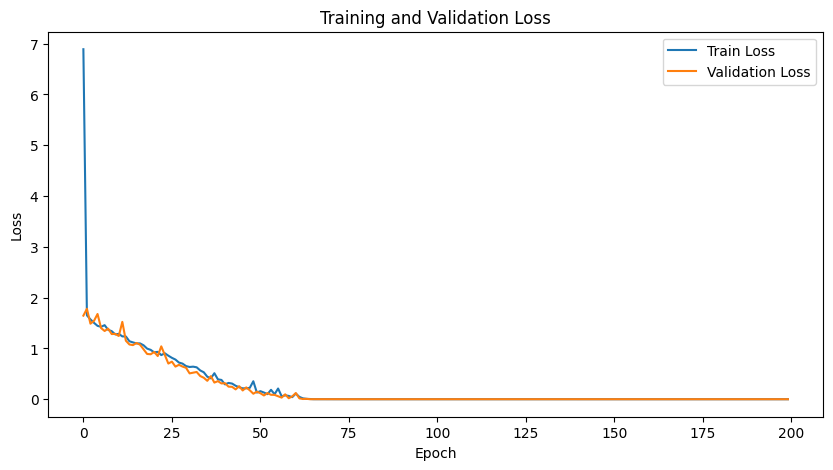

In [ ]:
train_model(model, criterion, optimizer, scheduler, client_train_dataloader, client_val_dataloader, client_train_data, client_validation_data, device, min_delta=0.05, patience=3)

Test model

In [ ]:
evaluation_model(model, criterion, client_test_dataloader)

The function tok 0.1624 seconds to execute.


61.199999999999996

Model predictions visualization.